In [1]:
import os
import pandas as pd
from tqdm import tqdm
import torch

from sklearn.metrics.pairwise import cosine_similarity
from rdkit.Chem import CanonSmiles, MolFromSmiles, PandasTools, MolToSmiles

from mhfp.encoder import MHFPEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Disable warnings
from rdkit import RDLogger
import warnings

RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")
PandasTools.RenderImagesInAllDataFrames(images=True)

# Load model and training data

In [3]:
fingerprint_name = "mhfp6"
model_name = "rf"
model = torch.load(f"../models/{fingerprint_name}_{model_name}.pkl")

In [4]:
training_df = pd.read_csv("../data/splits/mhfp6_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,cmp_id,label
0,106238389,19585817,17313015,85580138,2283851,9308294,114891348,330151044,4622583,32705546,...,21431025,1416250,23808403,43519231,84245819,8268284,92664381,15029722,GJONUWKZTGXFCZ-UHFFFAOYSA-N,fungi
1,3517916,33988699,16482348,70316072,11199736,177666938,7058993,36401732,31460943,13779754,...,7031338,1416250,14468176,41181622,12309677,442438,39402493,119091590,KNKXUUOLURWKKV-UHFFFAOYSA-N,gram-negative


# Load testing data - Enamine Antibacterial Library

,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,ID,ROMol
0,Z19296260,391.398,391.398,0.849,-3.81,3,5,144.66,7,,
1,Z19495142,369.328,369.328,2.01,-4.81,1,6,131.56,8,,

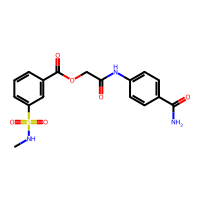
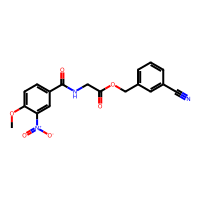

In [5]:
smiles_df = PandasTools.LoadSDF(
    "../data/benchmark/Enamine_Antibacterial_Library_32000cmpds_20231212.sdf"
)
smiles_df.head(2)

# Generate fingerprints

In [6]:
mhfp_encoder = MHFPEncoder(n_permutations=2048, seed=42)  # MHFP6 fingerprint

In [7]:
mhfp6_fingerprints = []

for mol in tqdm(smiles_df["ROMol"].values):
    # Generate the mol object
    smiles = MolToSmiles(mol)
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        mhfp6_fingerprints.append(None)
        continue

    mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))


smiles_df[fingerprint_name] = mhfp6_fingerprints

100%|██████████| 32000/32000 [04:02<00:00, 131.73it/s]


# Performing predictions

In [8]:
predictions = model.predict(smiles_df[fingerprint_name].tolist())
prediction_proba = model.predict_proba(smiles_df[fingerprint_name].tolist())
label_classes = model.classes_.tolist()

In [9]:
smiles_df["Prediction"] = predictions

In [10]:
probs = []

for idx, probability in enumerate(prediction_proba):
    predicted_class = predictions[idx]
    probs.append(probability[label_classes.index(predicted_class)])

smiles_df["Probability"] = probs

# Looking at the predictions

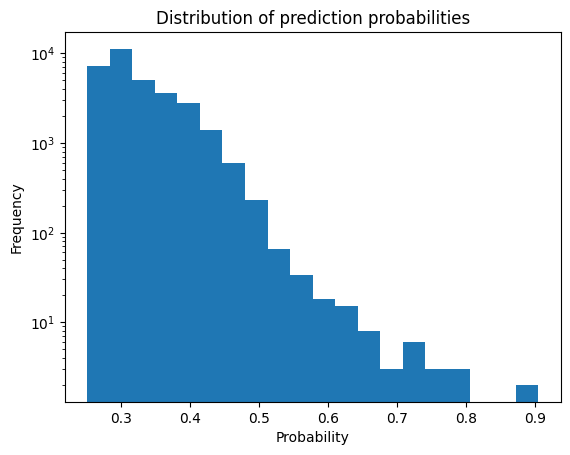

In [11]:
smiles_df["Probability"].plot(kind="hist", bins=20)
plt.yscale("log")
plt.xlabel("Probability")
plt.title("Distribution of prediction probabilities")
plt.show()

In [12]:
training_cmpds = []

for row in tqdm(training_df.values):
    cmpd_inchikey = row[-2]
    cmpd_label = row[-1]
    cmpd_fingerprint = row[:-2]
    training_cmpds.append(cmpd_fingerprint)

100%|██████████| 59361/59361 [00:00<00:00, 1580722.88it/s]


In [13]:
cosine_df = cosine_similarity(mhfp6_fingerprints, training_cmpds)

In [14]:
max_similarity_scores = []

for sim_row in tqdm(cosine_df):
    max_similarity_scores.append(max(sim_row))

100%|██████████| 32000/32000 [00:51<00:00, 618.13it/s]


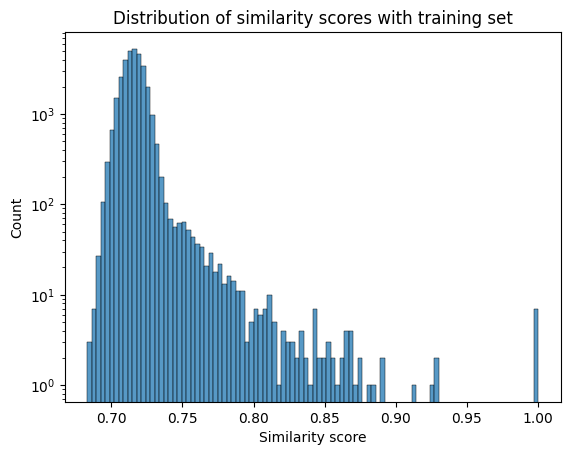

In [15]:
# Distribution of similarity scores with training set
sns.histplot(max_similarity_scores, bins=100)
plt.yscale("log")
plt.xlabel("Similarity score")
plt.title("Distribution of similarity scores with training set")
plt.show()

In [16]:
smiles_df["training_set_similarity"] = max_similarity_scores

In [17]:
smiles_df.sort_values("Probability", ascending=False, inplace=True)

,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,ID,ROMol,mhfp6,Prediction,Probability,training_set_similarity
5900,Z2583154272,511.051,511.558,0.252,-4.973,3,11,190.81,8,,,"[10595719, 49018156, 46860672, 53918226, 57503...",gram-negative,0.903780,0.844883
12842,Z1741977144,396.438,396.438,-0.283,-3.498,2,5,113.01,7,,,"[10595719, 49018156, 10235519, 53918226, 38894...",gram-positive,0.873435,1.000000
25977,Z1143251035,361.368,361.368,-0.508,-2.41,1,7,73.32,2,,,"[323435846, 33988699, 63689098, 47605079, 1119...",gram-positive,0.803137,1.000000
8499,Z2944548679,431.186,431.457,3.532,-3.782,1,6,90.39,5,,,"[246879222, 33988699, 45847754, 14540412, 1119...",gram-positive,0.799071,1.000000
26891,Z647975500,288.302,288.302,0.824,-3.17,1,4,90.06,5,,,"[7060930, 12093213, 102139561, 15292855, 41396...",fungi,0.779583,0.722564
3511,Z56939190,361.368,361.368,1.085,-2.85,1,6,81.16,3,,,"[323435846, 33023669, 63689098, 70316072, 1228...",gram-positive,0.770250,1.000000
628,Z1269203097,216.257,216.257,-2.187,-2.72,2,4,83.63,1,,,"[286099082, 323565121, 161342283, 53918226, 16...",gram-positive,0.760649,1.000000
6773,Z3016338143,344.774,344.774,0.959,-3.519,2,6,114.18,5,,,"[8847903, 44409534, 17313015, 82611468, 584489...",fungi,0.745286,0.719413
31371,Z416345606,325.774,325.774,1.353,-3.08,1,5,100.67,5,,,"[46420458, 33988699, 8411880, 66762991, 171838...",fungi,0.734917,0.716683
9015,Z414649268,297.348,297.348,1.332,-2.1,1,3,63.99,5,,,"[167361843, 12093213, 17313015, 224375838, 112...",fungi,0.728625,0.717865

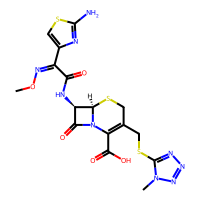
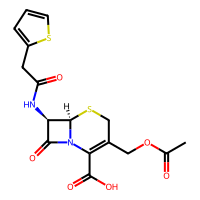
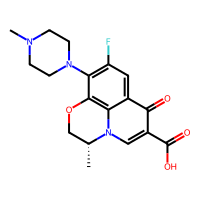
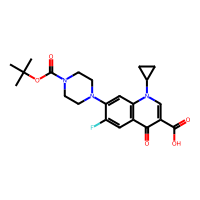
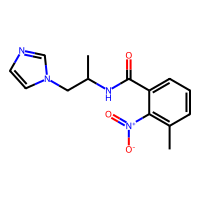
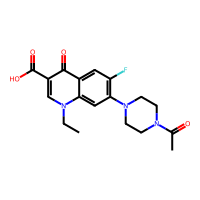
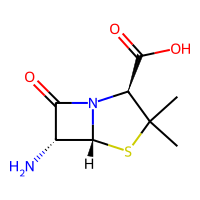
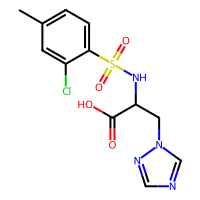
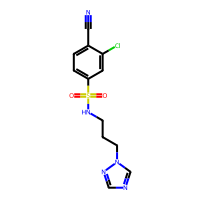
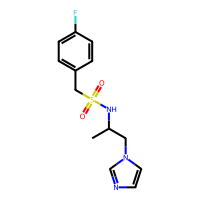

In [18]:
smiles_df.head(10)

In [19]:
smiles_df["training_set_similarity"].mean()

0.7167763993876638

# Saving the predictions

In [20]:
os.makedirs("../data/predictions", exist_ok=True)
smiles_df.to_csv("../data/predictions/antibacterial_predictions.csv", index=False)